<a href="https://colab.research.google.com/github/sraminics/CMPE297/blob/master/DogBreedClassifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Reading and Labeling the Data

In [1]:
import pandas as pd
from google.colab import drive
import os
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
if not(os.path.exists('/content/train')):
    print('Unzipping train.zip...')
    !unzip -q '/content/drive/My Drive/CMPE297/dog-breed-identification/train.zip'
    print('Unzipping test.zip...')
    !unzip -q '/content/drive/My Drive/CMPE297/dog-breed-identification/test.zip'
    print('finished')
else:
    print('Already loaded') 

Already loaded


In [3]:
labels_raw = pd.read_csv("/content/drive/My Drive/CMPE297/dog-breed-identification/labels.csv")
labels_raw['id'] = labels_raw['id']+'.jpg'
labels_raw.head()




,id,breed
0,000bec180eb18c7604dcecc8fe0dba07.jpg,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97.jpg,dingo
2,001cdf01b096e06d78e9e5112d419397.jpg,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d.jpg,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62.jpg,golden_retriever


In [4]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
BATCH = 32
labels = labels_raw


imagegen = ImageDataGenerator(
    rescale=1./255,
    zoom_range=.1,
    width_shift_range=.1,
    height_shift_range=.1,
    rotation_range=30,
    horizontal_flip=True,
    validation_split=.2
    )


train_generator = imagegen.flow_from_dataframe(
    dataframe=labels,
    directory='/content/train',
    x_col='id',
    y_col='breed',
    class_mode='categorical',
    target_size=(224,224),
    subset='training',
    batch_size=BATCH)


val_generator = imagegen.flow_from_dataframe(
    dataframe=labels,
    directory='/content/train',
    x_col='id',
    y_col='breed',
    class_mode='categorical',
    target_size=(224,224),
    subset='validation',
    batch_size=BATCH)


# test_datagen=ImageDataGenerator(rescale=1./255.)
# test_generator=test_datagen.flow_from_dataframe(
# dataframe=test_labels,
# directory="content/test/",
# x_col="id",
# y_col=None,
# batch_size=32,
# seed=42,
# shuffle=False,
# class_mode=None,
# target_size=(32,32))

Found 8178 validated image filenames belonging to 120 classes.
Found 2044 validated image filenames belonging to 120 classes.


In [5]:
from keras.applications import ResNet50V2

resnet = ResNet50V2(include_top=False, weights='imagenet', input_shape=(224,224,3))
resnet.trainable=False


Using TensorFlow backend.


In [6]:
resnet.summary()

Model: "resnet50v2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 114, 114, 64) 0           conv1_conv[0][0]                 
_________________________________________________________________________________________

In [7]:
from keras import models
from keras import layers
from keras import optimizers
from keras import losses

model = models.Sequential()
model.add(resnet)
model.add(layers.GlobalAveragePooling2D())
# model.add(layers.Dense(256, activation='relu')) Removing to increase Accuracy
model.add(layers.Dense(120, activation='softmax'))

model.compile(
    optimizer='adam', 
    loss=losses.categorical_crossentropy, 
    metrics=['accuracy'])

In [8]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50v2 (Model)           (None, 7, 7, 2048)        23564800  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 120)               245880    
Total params: 23,810,680
Trainable params: 245,880
Non-trainable params: 23,564,800
_________________________________________________________________


In [9]:
STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=val_generator.n//val_generator.batch_size
history = model.fit_generator(
      train_generator,
      steps_per_epoch=10,
      epochs=10,
      validation_data=val_generator,
      validation_steps=10)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/10
10/10 [==============================] - 15s 2s/step - loss: 5.0610 - acc: 0.0281 - val_loss: 5.5934 - val_acc: 0.0500
Epoch 2/10
10/10 [==============================] - 8s 787ms/step - loss: 4.8340 - acc: 0.0656 - val_loss: 4.3155 - val_acc: 0.1437
Epoch 3/10
10/10 [==============================] - 9s 886ms/step - loss: 4.2290 - acc: 0.1219 - val_loss: 3.7471 - val_acc: 0.2125
Epoch 4/10
10/10 [==============================] - 9s 921ms/step - loss: 3.8501 - acc: 0.1750 - val_loss: 3.2845 - val_acc: 0.2094
Epoch 5/10
10/10 [==============================] - 9s 908ms/step - loss: 3.5305 - acc: 0.2062 - val_loss: 2.9475 - val_acc: 0.2531
Epoch 6/10
10/10 [==============================] - 9s 907ms/step - loss: 3.2706 - acc: 0.2250 - val_loss: 2.6680 - val_acc: 0.3469
Epoch 7/10
10/10 [==============================] - 11s 1s/step - loss: 3.0713 - acc: 0.3406 - val_loss: 2.6336 - 

In [0]:
model.save('dog_breads.h5')

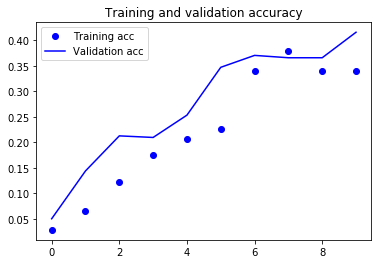

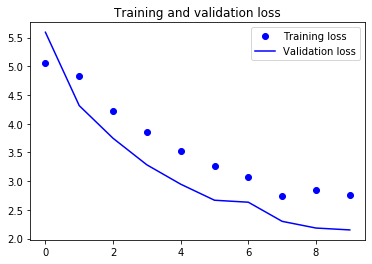

In [11]:
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

##Improving Accuracy By using Top 15 Dog Breeds(where there are more than 100)

In [12]:
labels_raw['breed'].value_counts()[:16]

scottish_deerhound      126
maltese_dog             117
afghan_hound            116
entlebucher             115
bernese_mountain_dog    114
shih-tzu                112
great_pyrenees          111
pomeranian              111
basenji                 110
samoyed                 109
airedale                107
tibetan_terrier         107
cairn                   106
leonberg                106
beagle                  105
japanese_spaniel        105
Name: breed, dtype: int64

In [0]:
array = ['scottish_deerhound', 'maltese_dog', 'afghan_hound', 'entlebucher', 'bernes_mountain_dog', 'shih-tzu', 'pomeranian', 'great_pyrenees', 'basenji', 'samoyed', 'airedale', 'tibetan_terrier', 'leonberg', 'cairn', 'japanese_spaniel', 'beagle']
labels_10_raw = labels_raw.loc[labels_raw['breed'].isin(array)]

In [14]:
labels_10_raw.head()

,id,breed
8,003df8b8a8b05244b1d920bb6cf451f9.jpg,basenji
9,0042188c895a2f14ef64a918ed9c7b64.jpg,scottish_deerhound
12,00693b8bc2470375cc744a6391d397ec.jpg,maltese_dog
29,00bee065dcec471f26394855c5c2f3de.jpg,cairn
48,013f8fdf6d638c7bb042f5f17e8a9fdc.jpg,tibetan_terrier


In [15]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
BATCH = 32
labels = labels_10_raw


imagegen = ImageDataGenerator(
    rescale=1./255,
    zoom_range=.1,
    width_shift_range=.1,
    height_shift_range=.1,
    rotation_range=30,
    horizontal_flip=True,
    validation_split=.2
    )


train_10_generator = imagegen.flow_from_dataframe(
    dataframe=labels,
    directory='/content/train',
    x_col='id',
    y_col='breed',
    class_mode='categorical',
    target_size=(224,224),
    subset='training',
    batch_size=BATCH)


val_10_generator = imagegen.flow_from_dataframe(
    dataframe=labels,
    directory='/content/train',
    x_col='id',
    y_col='breed',
    class_mode='categorical',
    target_size=(224,224),
    subset='validation',
    batch_size=BATCH)

Found 1331 validated image filenames belonging to 15 classes.
Found 332 validated image filenames belonging to 15 classes.


In [0]:
from keras import models
from keras import layers
from keras import optimizers
from keras import losses

model = models.Sequential()
model.add(resnet)
model.add(layers.GlobalAveragePooling2D())
# model.add(layers.Dense(256, activation='relu')) Removing to increase Accuracy
model.add(layers.Dense(15, activation='softmax'))

model.compile(
    optimizer='adam', 
    loss=losses.categorical_crossentropy, 
    metrics=['accuracy'])

In [17]:
history10 = model.fit_generator(
      train_10_generator,
      steps_per_epoch=10,
      epochs=10,
      validation_data=val_10_generator,
      validation_steps=10,
      shuffle=True)

Epoch 1/10
10/10 [==============================] - 14s 1s/step - loss: 2.7601 - acc: 0.1187 - val_loss: 2.2165 - val_acc: 0.3031
Epoch 2/10
10/10 [==============================] - 12s 1s/step - loss: 2.0171 - acc: 0.4022 - val_loss: 1.2894 - val_acc: 0.5800
Epoch 3/10
10/10 [==============================] - 9s 897ms/step - loss: 1.6190 - acc: 0.5406 - val_loss: 0.7495 - val_acc: 0.7667
Epoch 4/10
10/10 [==============================] - 7s 664ms/step - loss: 1.2039 - acc: 0.6750 - val_loss: 0.6746 - val_acc: 0.8033
Epoch 5/10
10/10 [==============================] - 11s 1s/step - loss: 0.9761 - acc: 0.7438 - val_loss: 0.5298 - val_acc: 0.8300
Epoch 6/10
10/10 [==============================] - 8s 840ms/step - loss: 0.8586 - acc: 0.7719 - val_loss: 0.5275 - val_acc: 0.8300
Epoch 7/10
10/10 [==============================] - 8s 837ms/step - loss: 0.8148 - acc: 0.7937 - val_loss: 0.4418 - val_acc: 0.8567
Epoch 8/10
10/10 [==============================] - 8s 796ms/step - loss: 0.7434 -

In [0]:
model.save('dog_breads_top_10.h5')

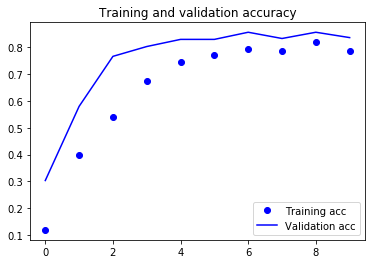

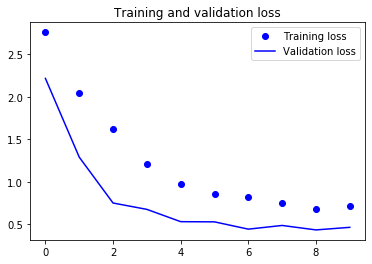

In [19]:
import matplotlib.pyplot as plt
acc = history10.history['acc']
val_acc = history10.history['val_acc']
loss = history10.history['loss']
val_loss = history10.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

##Visualization

In [20]:
from keras.models import load_model

model = load_model('dog_breads_top_10.h5')
model.summary()  # As a reminder.

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50v2 (Model)           (None, 7, 7, 2048)        23564800  
_________________________________________________________________
global_average_pooling2d_2 ( (None, 2048)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 15)                30735     
Total params: 23,595,535
Trainable params: 23,550,095
Non-trainable params: 45,440
_________________________________________________________________


/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:350: UserWarning: Error in loading the saved optimizer state. As a result, your model is starting with a freshly initialized optimizer.
  warnings.warn('Error in loading the saved optimizer '


In [21]:
img_path = '/content/test/0f56064b344e608e11a41e3523eb3b89.jpg'

# We preprocess the image into a 4D tensor
from keras.preprocessing import image
import numpy as np

img = image.load_img(img_path, target_size=(224, 224))
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)
# Remember that the model was trained on inputs
# that were preprocessed in the following way:
img_tensor /= 255.

print(img_tensor.shape)

(1, 224, 224, 3)


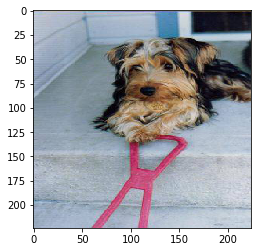

In [22]:
import matplotlib.pyplot as plt

plt.imshow(img_tensor[0])
plt.show()

In [0]:

from keras.applications import ResNet50V2
from keras import backend as K

model = ResNet50V2(include_top=False, weights='imagenet', input_shape=(224,224,3))

layer_name = 'conv2_block3_1_conv'
filter_index = 0

layer_output = model.get_layer(layer_name).output
loss = K.mean(layer_output[:, :, :, filter_index])

In [0]:
grads = K.gradients(loss, model.input)[0]

In [0]:
grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)

In [0]:
iterate = K.function([model.input], [loss, grads])

# Let's test it:
import numpy as np
loss_value, grads_value = iterate([np.zeros((1, 150, 150, 3))])

In [0]:
input_img_data = np.random.random((1, 224, 224, 3)) * 20 + 128.

# Run gradient ascent for 40 steps
step = 1.  # this is the magnitude of each gradient update
for i in range(40):
    # Compute the loss value and gradient value
    loss_value, grads_value = iterate([input_img_data])
    # Here we adjust the input image in the direction that maximizes the loss
    input_img_data += grads_value * step

In [0]:
def deprocess_image(x):
    # normalize tensor: center on 0., ensure std is 0.1
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1

    # clip to [0, 1]
    x += 0.5
    x = np.clip(x, 0, 1)

    # convert to RGB array
    x *= 255
    x = np.clip(x, 0, 255).astype('uint8')
    return x

In [0]:
def generate_pattern(layer_name, filter_index, size=150):
    # Build a loss function that maximizes the activation
    # of the nth filter of the layer considered.
    layer_output = model.get_layer(layer_name).output
    loss = K.mean(layer_output[:, :, :, filter_index])

    # Compute the gradient of the input picture wrt this loss
    grads = K.gradients(loss, model.input)[0]

    # Normalization trick: we normalize the gradient
    grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)

    # This function returns the loss and grads given the input picture
    iterate = K.function([model.input], [loss, grads])
    
    # We start from a gray image with some noise
    input_img_data = np.random.random((1, size, size, 3)) * 20 + 128.

    # Run gradient ascent for 40 steps
    step = 1.
    for i in range(40):
        loss_value, grads_value = iterate([input_img_data])
        input_img_data += grads_value * step
        
    img = input_img_data[0]
    return deprocess_image(img)

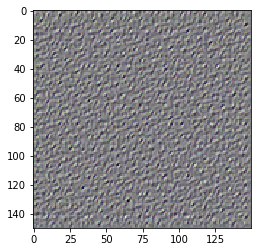

In [30]:
plt.imshow(generate_pattern('conv2_block3_1_conv', 0))
plt.show()

In [0]:
for layer_name in ['conv2_block1_1_conv', 'conv2_block2_1_conv', 'conv2_block3_1_conv', 'conv2_block4_1_conv']:
    size = 64
    margin = 5

    # This a empty (black) image where we will store our results.
    results = np.zeros((8 * size + 7 * margin, 8 * size + 7 * margin, 3))

    for i in range(8):  # iterate over the rows of our results grid
        for j in range(8):  # iterate over the columns of our results grid
            # Generate the pattern for filter `i + (j * 8)` in `layer_name`
            filter_img = generate_pattern(layer_name, i + (j * 8), size=size)

            # Put the result in the square `(i, j)` of the results grid
            horizontal_start = i * size + i * margin
            horizontal_end = horizontal_start + size
            vertical_start = j * size + j * margin
            vertical_end = vertical_start + size
            results[horizontal_start: horizontal_end, vertical_start: vertical_end, :] = filter_img

    results /= 255
    # Display the results grid
    plt.figure(figsize=(20, 20))
    plt.imshow(results)
    plt.show()

In [0]:
plt.imshow(generate_pattern('conv2_block3_1_conv', 0))
plt.show()